In [1]:
!pip install --quiet python-path dicto pyyaml

In [2]:
%matplotlib inline
import pickle
import heapq
import dicto as do
import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from python_path import PythonPath
with PythonPath("/code/traffic_sign_classifier/"):
    from german_traffic_densenet import model_fn
    from german_traffic_dataset import input_fn

In [3]:
params = do.load("/code/traffic_sign_classifier/configs.yml")

In [4]:
with open("/data/valid.p", "rb") as fd:
    valid = pickle.load(fd)

In [5]:
validate_input_fn = lambda : input_fn(valid['features'].astype(np.float32), valid['labels'].astype(np.int32), params.train_params, training=False)

In [6]:
classifier = tf.estimator.Estimator(model_fn, model_dir=params.model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/models/paper_densenet_normalized_augmented', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f63fee6b208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
classifier.evaluate(input_fn=validate_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-04-18:47:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/paper_densenet_normalized_augmented/model.ckpt-55937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-04-18:48:25
INFO:tensorflow:Saving dict for global step 55937: accuracy = 0.961591, global_step = 55937, loss = 35.9667
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 55937: /models/paper_densenet_normalized_augmented/model.ckpt-55937


{'accuracy': 0.96159089, 'loss': 35.966679, 'global_step': 55937}

In [8]:
test_images = [file.path for file in os.scandir("/code/test_images/")]
#print(test_images)
test_images = [ x for x in test_images if "jpg" in x]
print(test_images, len(test_images))

['/code/test_images/35.jpg', '/code/test_images/30.jpg', '/code/test_images/21.jpg', '/code/test_images/24.jpg', '/code/test_images/22.jpg', '/code/test_images/25.jpg', '/code/test_images/39.jpg', '/code/test_images/1.jpg', '/code/test_images/13.jpg', '/code/test_images/6.jpg', '/code/test_images/31.jpg', '/code/test_images/38.jpg', '/code/test_images/3.jpg', '/code/test_images/29.jpg', '/code/test_images/16.jpg'] 15


In [9]:
def predict_input_fn(file_list,):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    # ds = ds.batch(batch)
    ds = ds.map(tf.read_file)
    ds = ds.map(lambda x: tf.image.decode_jpeg(x, channels=3, dct_method="INTEGER_ACCURATE"))
    ds = ds.map( lambda x: tf.image.convert_image_dtype(x, tf.float32) )
    #ds = ds.map(lambda x: tf.image.resize_images(x, (32,32), align_corners=True, method=tf.image.ResizeMethod.AREA))
    ds = ds.batch(len(file_list))
    return ds

In [10]:
test_images_ds = predict_input_fn(test_images)

In [11]:
test_images_iterator = test_images_ds.make_one_shot_iterator()
iterator_ops = test_images_iterator.get_next()

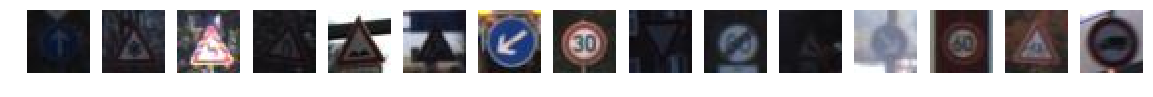

['35.jpg', '30.jpg', '21.jpg', '24.jpg', '22.jpg', '25.jpg', '39.jpg', '1.jpg', '13.jpg', '6.jpg', '31.jpg', '38.jpg', '3.jpg', '29.jpg', '16.jpg']


In [12]:
fig = plt.figure(figsize=(20, 20))
with tf.Session() as sess:
    images = sess.run(iterator_ops)
    for i, image in enumerate(images):
        fig.add_subplot(1, 15, i+1)
        plt.axis('off')
        plt.imshow(image)
        

plt.show()
print(list(map( lambda x: os.path.split(x)[-1], test_images)))
labels = list(map( lambda x: os.path.split(x)[-1], test_images))

In [13]:
classifier.latest_checkpoint()

'/models/paper_densenet_normalized_augmented/model.ckpt-55937'

In [14]:
predictions = classifier.predict(input_fn= lambda : predict_input_fn(test_images))

In [15]:
for i, prediction in enumerate(predictions):
    print("prediction: ", prediction['class_ids'], "label: ", labels[i])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/paper_densenet_normalized_augmented/model.ckpt-55937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
prediction:  35 label:  35.jpg
prediction:  30 label:  30.jpg
prediction:  31 label:  21.jpg
prediction:  24 label:  24.jpg
prediction:  22 label:  22.jpg
prediction:  1 label:  25.jpg
prediction:  39 label:  39.jpg
prediction:  1 label:  1.jpg
prediction:  13 label:  13.jpg
prediction:  6 label:  6.jpg
prediction:  31 label:  31.jpg
prediction:  38 label:  38.jpg
prediction:  3 label:  3.jpg
prediction:  29 label:  29.jpg
prediction:  16 label:  16.jpg


In [16]:
test_external_images = [file.path for file in os.scandir("/code/test_images/external/")]
#print(test_images)
#test_images = [ x for x in test_images if "jpg" in x]
print(test_images, len(test_images))

['/code/test_images/35.jpg', '/code/test_images/30.jpg', '/code/test_images/21.jpg', '/code/test_images/24.jpg', '/code/test_images/22.jpg', '/code/test_images/25.jpg', '/code/test_images/39.jpg', '/code/test_images/1.jpg', '/code/test_images/13.jpg', '/code/test_images/6.jpg', '/code/test_images/31.jpg', '/code/test_images/38.jpg', '/code/test_images/3.jpg', '/code/test_images/29.jpg', '/code/test_images/16.jpg'] 15


In [17]:
def predict_external_input_fn(file_list,):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    # ds = ds.batch(batch)
    ds = ds.map(tf.read_file)
    ds = ds.map(lambda x: tf.image.decode_jpeg(x, channels=3, dct_method="INTEGER_ACCURATE"))
    ds = ds.map( lambda x: tf.image.convert_image_dtype(x, tf.float32) )
    ds = ds.map(lambda x: tf.image.resize_images(x, (32,32), align_corners=True))
    ds = ds.batch(len(file_list))
    return ds

In [18]:
predictions = classifier.predict(input_fn= lambda : predict_external_input_fn(test_external_images))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/paper_densenet_normalized_augmented/model.ckpt-55937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


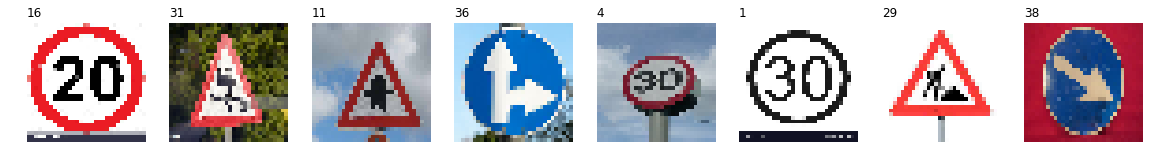

In [19]:
fig = plt.figure(figsize=(20, 20))
for i, prediction in enumerate(predictions):
    
    fig.add_subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(prediction['features'])
    plt.title(prediction['class_ids'], loc="left")
    
plt.show()

In [20]:
predictions = classifier.predict(input_fn= lambda : predict_external_input_fn(test_external_images))

In [21]:
def take_n_largest(array_elem, n):
    return heapq.nlargest(n, range(len(array_elem)), array_elem.take)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/paper_densenet_normalized_augmented/model.ckpt-55937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


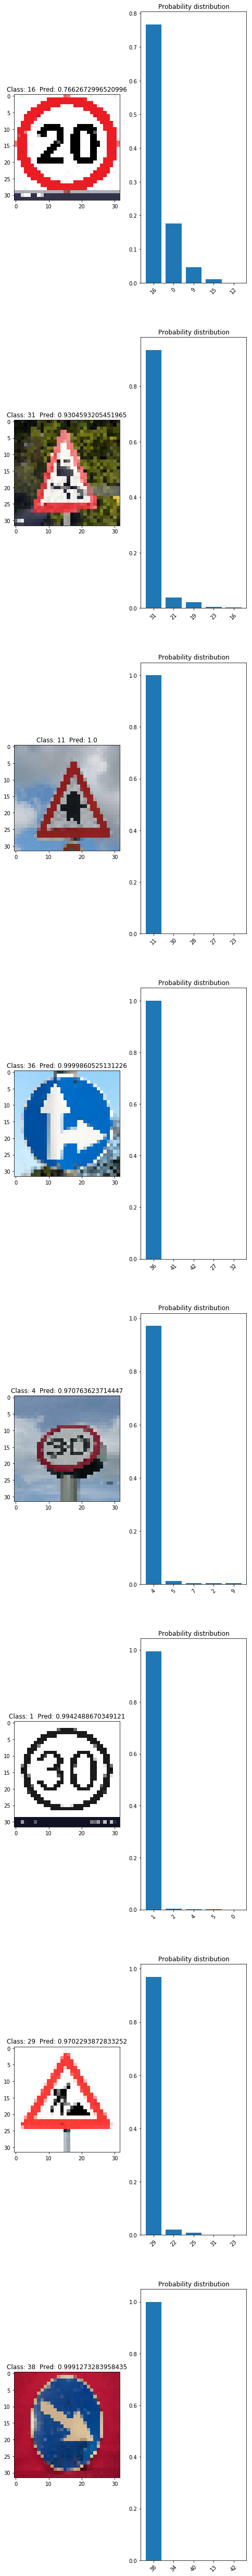

In [22]:
plt.figure(figsize=(8, 90))
plt_count = 1

for i, prediction in enumerate(predictions):
    labels = take_n_largest(prediction["probabilities"], 5)
    title = "Class: {}  Pred: {}".format(prediction['class_ids'], np.max(prediction['probabilities']))
    plt.subplot(8, 2, plt_count)
    plt.title(title)
    plt.imshow(prediction["features"])
    
    ax = plt.subplot(8, 2, plt_count + 1)
    plt.title("Probability distribution")
    
    labels = take_n_largest(prediction["probabilities"], 5)
    plt.bar(range(len(labels)), prediction["probabilities"][labels])
    ax.set_xticklabels([0] + labels, rotation=45)
    
    plt_count += 2